In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from scipy import sparse
sys.path.append("../spykesim")
import editsim
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
%matplotlib inline

In [4]:

def genpoisson_spiketrain(rate, dt, duration):
    offset = duration
    events = np.cumsum(np.random.exponential(scale = 1 / rate, size = int(duration*rate + offset)))
    return np.round(events[np.logical_and(0 < events, events < duration)], -int(np.log10(dt)))

def genpoisson_spiketrains(nneurons, rate, dt, duration):
    spike_timings = np.array([], dtype = np.float)
    spike_neurons = np.array([], dtype = np.int)
    for n in range(nneurons):
        spike_train = genpoisson_spiketrain(rate, dt, duration)
        spike_timings = np.r_[spike_timings, spike_train]
        spike_neurons = np.r_[spike_neurons, n * np.ones_like(spike_train, dtype = np.int)]
    return pd.DataFrame({
        "neuronid": spike_neurons,
        "spiketime": spike_timings
    })

def gen_sequence(nneurons = 10, seqlen = 0.1, dt = 0.001):
    return np.round(np.linspace(dt, seqlen-dt, nneurons), int(-np.log10(dt)))

def gen_sequences(neurons = np.arange(10), nsequences = 10, start = 0, end = 60, seqlen = 0.1, dt = 0.001, shrink = 1):
    spike_timings = np.array([], dtype = np.float)
    spike_neurons = np.array([], dtype = np.int)
    nneurons = len(neurons)
    sequence_onsets = np.random.choice(
        np.arange(start, end - seqlen, seqlen),
        nsequences,
        replace = False
    )
    for onset in sequence_onsets:
        spike_timings = np.r_[spike_timings, onset + gen_sequence(nneurons, seqlen / shrink, dt)]
        spike_neurons = np.r_[spike_neurons, neurons]
    return pd.DataFrame({
        "neuronid": spike_neurons,
        "spiketime": spike_timings
    }) 

def gen_sequences_with_replay(shrinkages = [2], neurons = np.arange(10), nsequences = 10, duration = 60, seqlen = 0.1, dt = 0.001):
    duration_per_type = duration / (len(shrinkages) + 1)
    sequences = gen_sequences(neurons,
                              nsequences,
                              0,
                              duration_per_type,
                              seqlen,
                              dt)
    for idx, shrinkage in enumerate(shrinkages):
        replay = gen_sequences(neurons,
                               nsequences,
                               duration_per_type * (idx + 1),
                               duration_per_type * (idx + 2),
                               seqlen,
                               dt, 
                               abs(shrinkage))
        if shrinkage < 0: # reverse replay
            replay = pd.DataFrame({
                "neuronid": replay.neuronid,
                "spiketime": np.copy(replay.spiketime[::-1])
            })
        sequences = pd.concat([sequences, replay])
    return sequences

In [6]:
dt = 0.001
# nsequences = 10
# seqlen = 0.3
nsequences = 5
seqlen = 0.1
shrinkages = [-5, 5]
nneurons = 10
duration = nsequences * seqlen * (len(shrinkages) + 1) + 0.2
nseqkinds = 3
df = pd.DataFrame()
for idx in range(nseqkinds):
    df_seq = gen_sequences_with_replay(
        shrinkages = shrinkages,
        neurons = np.arange(nneurons*(idx), nneurons*(idx+1)),
        nsequences = nsequences,
        duration = duration,
        seqlen = seqlen,
        dt = dt)
    df_seq = pd.DataFrame({
        "neuronid": df_seq.neuronid,
        "spiketime": np.copy(df_seq.spiketime + duration * idx + idx)
    })
    df = pd.concat([df, df_seq])

rate = 1
nneurons = nneurons*nseqkinds 
duration = duration*nseqkinds + nseqkinds
df_noise = genpoisson_spiketrains(nneurons, rate, dt, duration)
df = pd.concat([df, df_noise])

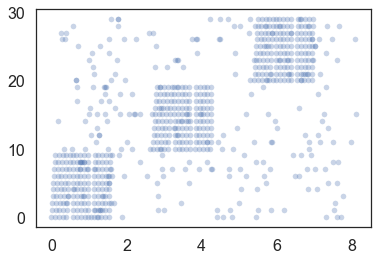

In [7]:
plt.plot(df.spiketime, df.neuronid, "b.", alpha = 0.3)

In [8]:
def df2binarray_csc(df, duration_ms = int(df.spiketime.max()*1000), binwidth = 1):
    neuronids = df.neuronid
    spikes_ms = df.spiketime * 1000
    nneurons = int(neuronids.max()+1)
    nrow = nneurons 
    ncol = int(duration_ms) // binwidth + 1000
    binarray_lil = sparse.lil_matrix((nrow, ncol))
    for neuronid in range(nneurons):
        spike_train_of_a_neuron = spikes_ms[neuronids == neuronid]
        bins = np.arange(0, ncol * binwidth, binwidth)
        digitized_spike_train_of_a_neuron = np.digitize(spike_train_of_a_neuron, bins) - 1
        binned_spike_train_of_a_neuron = np.bincount(digitized_spike_train_of_a_neuron)
        binarray_lil[neuronid, digitized_spike_train_of_a_neuron] = binned_spike_train_of_a_neuron[digitized_spike_train_of_a_neuron]
    return binarray_lil.tocsc()

In [9]:
from matplotlib import gridspec

binarray_csc = df2binarray_csc(df, duration_ms=int(duration*1000), binwidth = 1)
binmat = binarray_csc.toarray()

(0, 10)

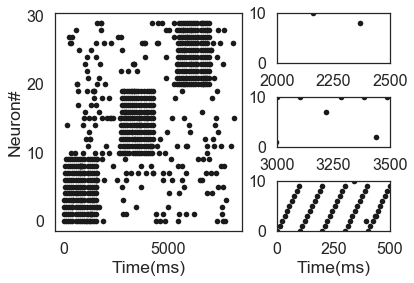

In [10]:
outer_grid = gridspec.GridSpec(3, 5, wspace=0.9, hspace = 0.7)
ax = plt.subplot(outer_grid[:, :3])
row, col = np.where(binmat == 1)
ax.plot(col, row, "k.")
ax.set_xlabel("Time(ms)")
ax.set_ylabel("Neuron#")
ax = plt.subplot(outer_grid[2, 3:])
ax.plot(col, row, "k.")
ax.set_xlabel("Time(ms)")
ax.set_xlim(0, 500)
ax.set_ylim(0, 10)
ax = plt.subplot(outer_grid[1, 3:])
ax.plot(col, row, "k.")
ax.set_xlim(3000, 3500)
ax.set_ylim(0, 10)
ax = plt.subplot(outer_grid[0, 3:])
ax.plot(col, row, "k.")
ax.set_xlim(2000, 2500)
ax.set_ylim(0, 10)

In [11]:
window = int(seqlen*1000)
a = 0.01

In [12]:
window = int(seqlen*1000)
a = 0.01
simmat, times = editsim.eval_simmat(binarray_csc, window, window, a = a, backend = "tqdm")

AttributeError: module 'editsim' has no attribute 'eval_simmat'

In [24]:
#%timeit -n 1 simmat, times = editsim.eval_simmat(binarray_csc, window, window, a = a, backend = "joblib")

In [14]:
%%timeit
editsim.eval_simmat(binarray_csc, window, window, a = a, backend = "multiprocessing1")

TypeError: must be real number, not list

In [17]:
%%timeit
editsim.eval_simmat(binarray_csc, window, window, a = a, backend = "multiprocessing2")

3.91 s ± 46.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%timeit -n 1 simmat, times = editsim.eval_simmat(binarray_csc, window, window, a = a, backend = "multiprocessing")

49.5 s ± 276 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
seqdf = pd.DataFrame({"bin": times}) # TODO: times -> binsに

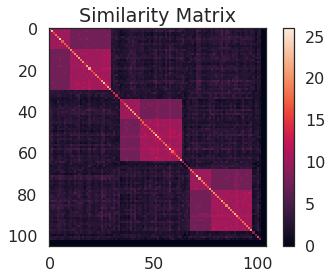

In [16]:
plt.imshow(simmat)
plt.colorbar()
plt.title("Similarity Matrix")

In [44]:
import hdbscan

cluster = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, metric="precomputed")
distmat = 1 / (1+simmat)
cluster.fit(distmat)
cluster.condensed_tree_.plot(select_clusters = True, selection_palette=sns.color_palette())

In [46]:
seqdf["seq"] = cluster.labels_
seqdf["seq"] = seqdf["seq"].astype("category")

In [47]:
from matplotlib import gridspec

NameError: name 'bins' is not defined

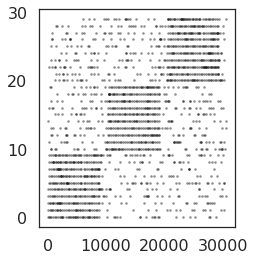

In [48]:
plt.figure()
outer_grid = gridspec.GridSpec(1, 5)
ax = plt.subplot(outer_grid[0, :3])
row, col = np.where(binmat == 1)
ax.plot(col, row, "k.", alpha = 0.5, markersize = 5)
label_colors = [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], "w"]
for b, label in zip(bins, cluster.labels_):
    ax.plot(np.array([b, b+window]), np.array([nneurons+2, nneurons+2]), color =  label_colors[label])
ax.set_ylim(-1, nneurons+5)
ax.set_xlabel("Time(ms)")
ax.set_ylabel("Neuron#")
ax.set_title("Detected Assemblies")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([0, 20000])
ax = plt.subplot(outer_grid[0, 3:])
ax.plot([-1], [-1], c = sns.color_palette()[0], label = "Assembly1")
ax.plot([-1], [-1], c = sns.color_palette()[1], label = "Assembly2")
ax.plot([-1], [-1], c = sns.color_palette()[2], label = "Assembly2")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

In [16]:
import multiprocessing

In [17]:
def eval_shrinkagevec(idx1, t1, times, binarray_csc, window, a):
    shrinkage_vec = np.ones(len(times))
    m1 = binarray_csc[:, t1:(t1+window)].toarray().astype(np.double)
    for idx2, t2 in enumerate(times):
        if idx1 == idx2:
            continue
        m2 = binarray_csc[:, t2:(t2+window)].toarray().astype(np.double)
        dp_max, dp_max_x, dp_max_y, bp, flip = editsim.clocal_exp_editsim_withbp_withflip(m1, m2, a=a)
        if bp.sum() > 0:
            dp_max, dp_max_x, dp_max_y, bp, flip = editsim.clocal_exp_editsim_withbp_withflip(m1, m2, a=a)
            shrinkage1 = editsim.eval_shrinkage(bp, dp_max_x, dp_max_y, flip)
            dp_max, dp_max_x, dp_max_y, bp, flip = editsim.clocal_exp_editsim_withbp_withflip(m2, m1, a=a)
            shrinkage2 = editsim.eval_shrinkage(bp, dp_max_x, dp_max_y, flip)
            shrinkage = shrinkage1 if abs(shrinkage1) > abs(shrinkage2) else shrinkage2
        else:
            shrinkage = 0
        shrinkage_vec[idx2] = shrinkage
    return shrinkage_vec, idx1

In [18]:
def eval_shrinkagemat(binarray_csc, window, a, times):
    shrinkage_mat = np.zeros((len(times), len(times)))
    pool = multiprocessing.Pool()
    jobs = []
    for idx1, t1 in enumerate(times):
        jobs.append(pool.apply_async(eval_shrinkagevec, args = (idx1, t1, times, binarray_csc, window, a)))
    for job in jobs:
        shrinkage_vec, idx1 = job.get()
        shrinkage_mat[idx1, :]  = shrinkage_vec
    pool.close()
    return shrinkage_mat

In [19]:
def draw_color_bar(ax, nstep = 100, min_ = 0, max_ = 1):
    step = 0.1
    Z = [[0,0],[0,0]]
    levels = np.linspace(min_,max_, nstep)
    CS3 = plt.contourf(Z, levels, ticks=[])
    cbar = plt.colorbar(CS3, cax=ax)
    cbar.set_ticks([min_, max_])
    return(ax)

In [66]:
shmat = eval_shrinkagemat(binarray_csc, window, a, times)

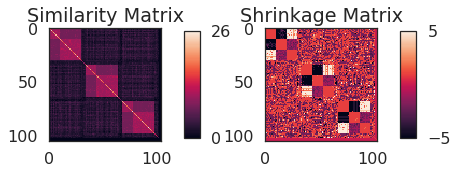

In [67]:
plt.figure()

grid1 = gridspec.GridSpec(8, 8)
grid1.update(left=0.05, right = 0.4)
ax = plt.subplot(grid1[:, :6])
ax.imshow(simmat, vmax = int(simmat.max()), vmin = 0)
ax.set_title("Similarity Matrix")
ax = plt.subplot(grid1[2:6, 7])
draw_color_bar(ax, min_ = 0, max_ = int(simmat.max()))

grid2 = gridspec.GridSpec(8, 8)
grid2.update(left=0.55, right = 0.9)
ax = plt.subplot(grid2[:, :6])
ax.imshow(shmat, vmin = -5, vmax = 5)
ax.set_title("Shrinkage Matrix")
ax = plt.subplot(grid2[2:6, 7])
draw_color_bar(ax, min_ = -5, max_ = 5)

In [68]:
uniq_labels = np.unique(seqdf.seq)
shtimes_list = []
shmat_list = []
for label in uniq_labels:
    if label == -1:
        continue
    shtimes = seqdf.bin[seqdf.seq == label]
    shtimes_list.append(shtimes)
    shmat_list.append(eval_shrinkagemat(binarray_csc, window, a, shtimes))

In [ ]:
for shmat in shmat_list:
    plt.imshow(shmat)
    print(shmat.max(), shmat.min())
    plt.colorbar()
    plt.show()

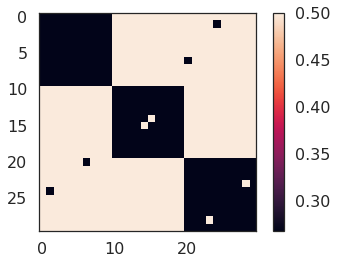

In [148]:
plt.imshow(distmat)
plt.colorbar()

In [190]:
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster.hierarchy import fcluster

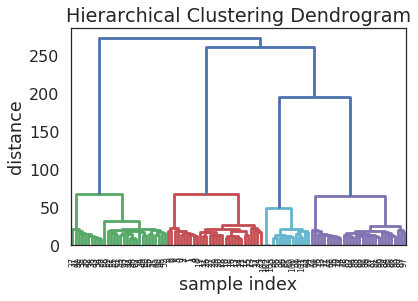

In [197]:
Z = linkage(simmat, 'ward')
fcluster(Z, 1)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
);

In [69]:
seqdf["shr"] = -1
for shtimes, shmat in zip(shtimes_list, shmat_list):
    rows, cols = np.where(np.logical_and(0.99 < shmat, shmat < 1.01)) # TODO params
    whshmat = np.zeros_like(shmat)
    for row, col in zip(rows, cols):
        whshmat[row, col] = shmat[row, col]
    distmat = 1 / (1 + whshmat)
    Z = linkage(whshmat, 'ward')
    seqdf.loc[shtimes.index, "shr"] = fcluster(Z, 1)
seqdf["shr"] = seqdf["shr"].astype('category')

NameError: name 'linkage' is not defined

In [252]:
seqidx = 1
shridx1 = seqdf.shr.unique()[
    np.array(
        [len(
            seqdf.query(
                "seq == {} and shr == {}".format(seqidx, shridx1)
            ).index) for shridx in seqdf.shr.unique()
        ]).argmax()
]
print(shridx1)

2


In [250]:
seqdf.query("seq == {}".format(seqidx))

,bin,seq,shr
0,0,1,2
1,300,1,2
2,600,1,2
3,900,1,2
4,1200,1,2
5,1500,1,2
6,1800,1,2
7,2100,1,2
8,2400,1,2
9,2700,1,2


In [17]:
from functools import partial

In [22]:
def f(x, y, z):
    return x+y+z

In [23]:
list(map(partial(f, 10, 1), [10, 20]))

[21, 31]

In [78]:
seqidx = 1
def select_seq(seqdf, seqidx, shridx):
    return seqdf.query(
        "seq == {} and shr == {}".format(
            seqidx, shridx
        )
    )
def scale(seqdf, seqidx, shridx):
    return len(
        select_seq(
            seqdf, seqidx, shridx
        ).index
    )
get_scale = partial(
    scale, seqdf, seqidx
)

In [80]:
get_scale(2)

0

In [ ]:
for seqidx in seqdf.seq.unique():
    # 適当なidxから始める -> sortして中央に来たidxをAwakeとみなすか？
    if seqidx == -1:
        continue
    n_elems = []
    # 要素数最大のidxを抜き出す
    shridx1 = seqdf.shr.unique()[
        np.array(
            [len(
                seqdf.query(
                    "seq == {} and shr == {}".format(seqidx, shridx1)
                ).index) for shridx in seqdf.shr.unique() if shridx != -1
            ]).argmax()
    ]
    get_scale = partial(
        seqdf.query(
        "seq == {} and shr == {}".format, seqidx
    )
    same_scale = seqdf.query(
        "seq == {} and shr == {}".format(seqidx, shridx1)
    ).index
    for shridx2 in seqdf.shr.unique():
        if shridx1 == shridx2 or shridx2 == -1:
            continue
        different_scale = seqdf.query(
            "seq == {} and shr == {}".format(seqidx, shridx2)
        ).index
        scales = []
        for idx1 in same_scale:
            for idx2 in different_scale:
                scales.append(shmat[idx1, idx2])
        print("sc",  np.median(scales) if len(scales) != 0 else np.nan)

In [269]:
for seqidx in seqdf.seq.unique():
    # 適当なidxから始める -> sortして中央に来たidxをAwakeとみなすか？
    if seqidx == -1:
        continue
    n_elems = []
    # 要素数最大のidxを抜き出す
    shridx1 = seqdf.shr.unique()[
        np.array(
            [len(
                seqdf.query(
                    "seq == {} and shr == {}".format(seqidx, shridx1)
                ).index) for shridx in seqdf.shr.unique() if shridx != -1
            ]).argmax()
    ]
    same_scale = seqdf.query(
        "seq == {} and shr == {}".format(seqidx, shridx1)
    ).index
    for shridx2 in seqdf.shr.unique():
        if shridx1 == shridx2 or shridx2 == -1:
            continue
        different_scale = seqdf.query(
            "seq == {} and shr == {}".format(seqidx, shridx2)
        ).index
        scales = []
        for idx1 in same_scale:
            for idx2 in different_scale:
                scales.append(shmat[idx1, idx2])
        print("sc",  np.median(scales) if len(scales) != 0 else np.nan)

sc -6.0
sc 5.0
sc nan
sc -6.0
sc 5.0
sc nan
sc -6.0
sc 1.0
sc 4.5


In [243]:
np.median(shmat)

0.0

In [238]:
shmat[indices]

array([[-2., -2.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       ..., 
       [-2.,  1.,  3., ...,  0.,  0.,  0.],
       [-2.,  1.,  1., ...,  0.,  0.,  0.],
       [-2., -2., -2., ...,  0.,  0.,  0.]])

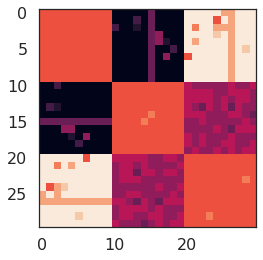

In [232]:
plt.imshow(shmat)

In [224]:
seqdf.shr.unique()

[2, 1, 3, -1, 4]
Categories (5, int64): [2, 1, 3, -1, 4]

In [234]:
indices = seqdf.query("seq == {} and shr != {}".format(0, 1)).index
indices

Int64Index([68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 88, 89, 90, 91, 92, 93, 94,
            95, 96, 97],
           dtype='int64')

In [72]:
seqdf

,bin,seq,test,shr
0,0,1,0,0.0
1,300,1,0,0.0
2,600,1,0,0.0
3,900,1,0,0.0
4,1200,1,0,0.0
5,1500,1,0,1.0
6,1800,1,0,1.0
7,2100,1,0,1.0
8,2400,1,0,1.0
9,2700,1,0,1.0


In [65]:
seqdf.loc[shtimes.index, "shr"] = cluster.labels_

In [66]:
seqdf

,bin,seq,test,shr
0,0,1,0,NaN
1,300,1,0,NaN
2,600,1,0,NaN
3,900,1,0,NaN
4,1200,1,0,NaN
5,1500,1,0,NaN
6,1800,1,0,NaN
7,2100,1,0,NaN
8,2400,1,0,NaN
9,2700,1,0,NaN


In [62]:
seqdf.iloc[shtimes_list[2].index]["seq"]

38    2
39    2
40    2
41    2
42    2
43    2
44    2
45    2
46    2
47    2
48    2
49    2
50    2
51    2
52    2
Name: seq, dtype: int64

In [56]:
seqdf["test"] = 0

In [60]:
seqdf.head( )

,bin,seq,test
0,0,1,0
1,300,1,0
2,600,1,0
3,900,1,0
4,1200,1,0


In [53]:
tmp.index

Int64Index([38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52], dtype='int64')

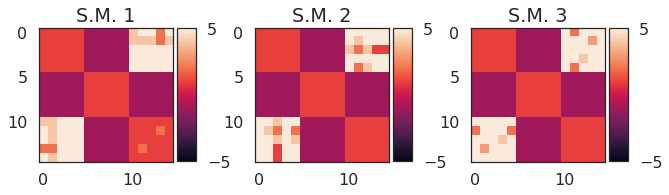

In [29]:
plt.figure(figsize = (10, 5))

grid1 = gridspec.GridSpec(8, 8)
grid1.update(left=0.05, right = 0.3)
ax = plt.subplot(grid1[:, :6])
ax.imshow(shmat1, vmin = -5, vmax = 5)
ax.set_title("S.M. 1")
ax = plt.subplot(grid1[2:6, 6])
draw_color_bar(ax, min_ = -5, max_ = 5)


grid2 = gridspec.GridSpec(8, 8)
grid2.update(left=0.35, right = 0.6)
ax = plt.subplot(grid2[:, :6])
ax.imshow(shmat2, vmin = -5, vmax = 5)
ax.set_title("S.M. 2")
ax = plt.subplot(grid2[2:6, 6])
draw_color_bar(ax, min_ = -5, max_ = 5)

grid3 = gridspec.GridSpec(8, 8)
grid3.update(left=0.65, right = 0.9)
ax = plt.subplot(grid3[:, :6])
ax.imshow(shmat3, vmin = -5, vmax = 5)
ax.set_title("S.M. 3")
ax = plt.subplot(grid3[2:6, 6])
draw_color_bar(ax, min_ = -5, max_ = 5)

# ここからインチキ

In [34]:
cluster.labels_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
       -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1, -1, -1, -1, -1, -1])

In [54]:
shlabel = np.array([
          1,  1,  1,  1,  1,
          -5,  -5,  -5,  -5,  -5,
          5,  5,  5,  5,  5,
    0, 0, 0, 0,
          1,  1,  1,  1,  1,
          -5,  -5,  -5,  -5,  -5,
          5,  5,  5,  5,  5,    
    0, 0, 0, 0,
          1,  1,  1,  1,  1,
          -5,  -5,  -5,  -5,  -5,
          5,  5,  5,  5,  5,
          0, 0, 0, 0, 0, 0, 0])

[]

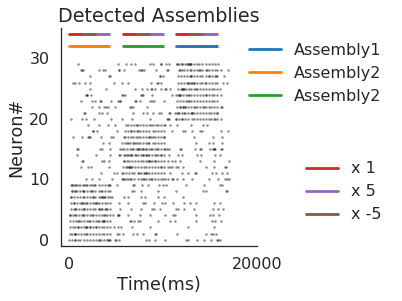

In [55]:
plt.figure()
outer_grid = gridspec.GridSpec(2, 5)
ax = plt.subplot(outer_grid[:, :3])
row, col = np.where(binmat == 1)
ax.plot(col, row, "k.", alpha = 0.5, markersize = 5)
shlabel_colors = [sns.color_palette()[3], sns.color_palette()[4], sns.color_palette()[5], "w"]
label_colors = [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], "w"]
for t, label, shlabel in zip(times, cluster.labels_, shlabel):
    ax.plot(np.array([t, t+window]), np.array([nneurons+2, nneurons+2]), color =  label_colors[label])
    if shlabel == 0:
        c = shlabel_colors[-1]
    elif shlabel == 1:
        c = shlabel_colors[0]
    elif shlabel == 5:
        c = shlabel_colors[1]
    else:
        c = shlabel_colors[2]
    ax.plot(np.array([t, t+window]), np.array([nneurons+4, nneurons+4]), color =  c)
ax.set_ylim(-1, nneurons+5)
ax.set_xlabel("Time(ms)")
ax.set_ylabel("Neuron#")
ax.set_title("Detected Assemblies")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([0, 20000])
ax = plt.subplot(outer_grid[0, 3:])
ax.plot([-1], [-1], c = sns.color_palette()[0], label = "Assembly1")
ax.plot([-1], [-1], c = sns.color_palette()[1], label = "Assembly2")
ax.plot([-1], [-1], c = sns.color_palette()[2], label = "Assembly2")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])
ax = plt.subplot(outer_grid[1, 3:])
ax.plot([-1], [-1], c = sns.color_palette()[3], label = "x 1")
ax.plot([-1], [-1], c = sns.color_palette()[4], label = "x 5")
ax.plot([-1], [-1], c = sns.color_palette()[5], label = "x -5")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

# ここまでインチキ

In [56]:
rows, cols = np.where(np.logical_and(0.9 < shmat1, shmat1 < 1.1))
whshmat1 = np.zeros_like(shmat1)
for row, col in zip(rows, cols):
    whshmat1[row, col] = shmat1[row, col]
rows, cols = np.where(np.logical_and(0.9 < shmat2, shmat2 < 1.1))
whshmat2 = np.zeros_like(shmat2)
for row, col in zip(rows, cols):
    whshmat2[row, col] = shmat2[row, col]    
rows, cols = np.where(np.logical_and(0.9 < shmat3, shmat3 < 1.1))
whshmat3 = np.zeros_like(shmat3)
for row, col in zip(rows, cols):
    whshmat3[row, col] = shmat3[row, col]

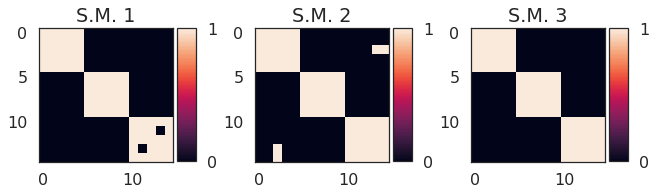

In [57]:
plt.figure(figsize = (10, 5))

grid1 = gridspec.GridSpec(8, 8)
grid1.update(left=0.05, right = 0.3)
ax = plt.subplot(grid1[:, :6])
ax.imshow(whshmat1, vmin = 0, vmax = 1)
ax.set_title("S.M. 1")
ax = plt.subplot(grid1[2:6, 6])
draw_color_bar(ax, min_ = 0, max_ = 1)


grid2 = gridspec.GridSpec(8, 8)
grid2.update(left=0.35, right = 0.6)
ax = plt.subplot(grid2[:, :6])
ax.imshow(whshmat2, vmin = 0, vmax = 1)
ax.set_title("S.M. 2")
ax = plt.subplot(grid2[2:6, 6])
draw_color_bar(ax, min_ = 0, max_ = 1)

grid3 = gridspec.GridSpec(8, 8)
grid3.update(left=0.65, right = 0.9)
ax = plt.subplot(grid3[:, :6])
ax.imshow(whshmat3, vmin = 0, vmax = 1)
ax.set_title("S.M. 3")
ax = plt.subplot(grid3[2:6, 6])
draw_color_bar(ax, min_ = 0, max_ = 1)

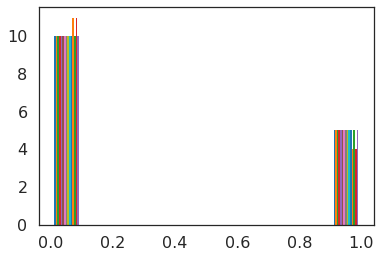

In [63]:
plt.hist(whshmat1);

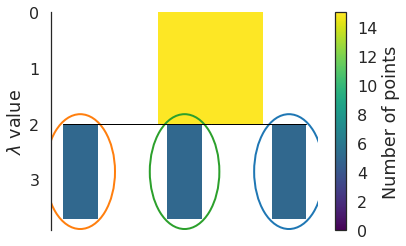

In [78]:
cluster1 = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=True, metric="precomputed")
distmat = 1 / (1 + np.exp(whshmat1))
cluster1.fit(distmat)
cluster1.condensed_tree_.plot(select_clusters = True, selection_palette=sns.color_palette())

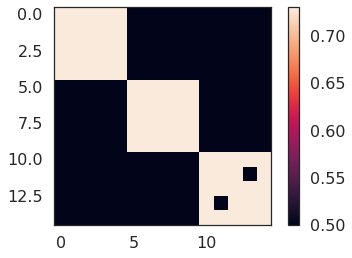

In [77]:
plt.imshow(distmat)
plt.colorbar()

In [113]:
rows, cols = np.where(np.logical_and(0.8 < shmat1, shmat1 < 1.2))
rows, cols
whshmat1 = np.zeros_like(shmat1)
for row, col in zip(rows, cols):
    whshmat1[row, col] = shmat1[row, col]

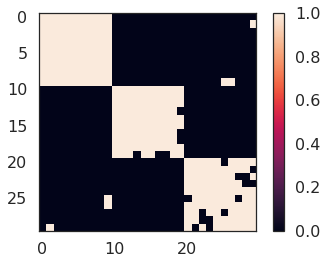

In [115]:
plt.imshow(whshmat1)
plt.colorbar()

TypeError: Invalid dimensions for image data

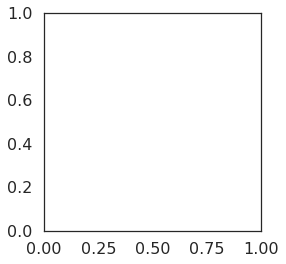

In [99]:
plt.imshow(shmat1[shmat1 == 1], vmin=-5, vmax = 5)
plt.colorbar()

/home/kei/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/hdbscan/plots.py:381: RuntimeWarning: invalid value encountered in double_scalars
  height = (c_bounds[CB_TOP] - c_bounds[CB_BOTTOM])


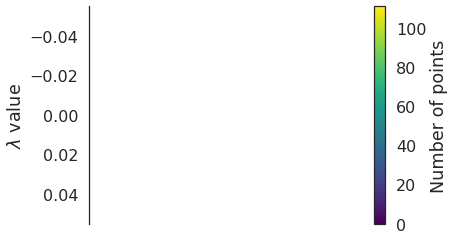

In [95]:
shclu1 = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, metric="precomputed")
shclu1.fit(np.abs(shmat1))
shclu1.condensed_tree_.plot(select_clusters = True, selection_palette=sns.color_palette())

In [92]:
shclu1.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])

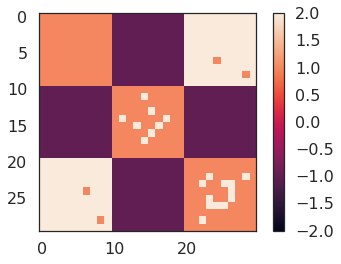

In [88]:
plt.imshow(shmat2, vmin=-2, vmax = 2)
plt.colorbar()

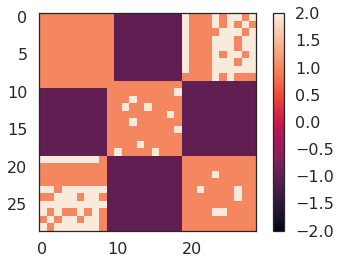

In [89]:
plt.imshow(shmat3, vmin=-2, vmax = 2)
plt.colorbar()

In [ ]:
nmats = len(mats)
simmat = np.zeros((nmats, nmats))
shrmat = np.ones((nmats, nmats))
for idx1, mat1 in enumerate(mats):
    for idx2, mat2 in enumerate(mats):
        if idx1 == idx2:
            continue
        m1, m2 = mat1.toarray().astype(np.double), mat2.toarray().astype(np.double)
        dp_max, dp_max_x, dp_max_y, bp, flip = editsim.clocal_exp_editsim_withbp_withflip(m1, m2, a=a)
        if bp.sum() > 0:
            dp_max, dp_max_x, dp_max_y, bp, flip = editsim.clocal_exp_editsim_withbp_withflip(m1, m2, a=a)
            shrinkage1 = editsim.eval_shrinkage(bp, dp_max_x, dp_max_y, flip)
            dp_max, dp_max_x, dp_max_y, bp, flip = editsim.clocal_exp_editsim_withbp_withflip(m2, m1, a=a)
            shrinkage2 = editsim.eval_shrinkage(bp, dp_max_x, dp_max_y, flip)
            shrinkage = shrinkage1 if shrinkage1 > shrinkage2 else shrinkage2
        else:
            shrinkage = 0
        simmat[idx1, idx2] = dp_max
        shrmat[idx1, idx2] = shrinkage

In [184]:
nmats = len(mats)
simmat = np.zeros((nmats, nmats))
shrmat = np.ones((nmats, nmats))
for idx1, mat1 in enumerate(mats):
    for idx2, mat2 in enumerate(mats):
        if idx1 == idx2:
            continue
        m1, m2 = mat1.toarray().astype(np.double), mat2.toarray().astype(np.double)
        dp_max, dp_max_x, dp_max_y, bp, flip = editsim.clocal_exp_editsim_withbp_withflip(m1, m2, a=a)
        if bp.sum() > 0:
            dp_max, dp_max_x, dp_max_y, bp, flip = editsim.clocal_exp_editsim_withbp_withflip(m1, m2, a=a)
            shrinkage1 = editsim.eval_shrinkage(bp, dp_max_x, dp_max_y, flip)
            dp_max, dp_max_x, dp_max_y, bp, flip = editsim.clocal_exp_editsim_withbp_withflip(m2, m1, a=a)
            shrinkage2 = editsim.eval_shrinkage(bp, dp_max_x, dp_max_y, flip)
            shrinkage = shrinkage1 if shrinkage1 > shrinkage2 else shrinkage2
        else:
            shrinkage = 0
        simmat[idx1, idx2] = dp_max
        shrmat[idx1, idx2] = shrinkage

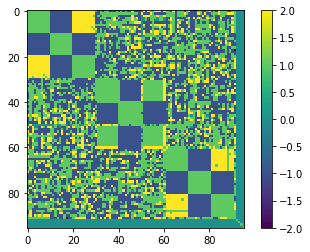

In [186]:
plt.imshow(shrmat, vmin = -2, vmax = 2)
plt.colorbar()

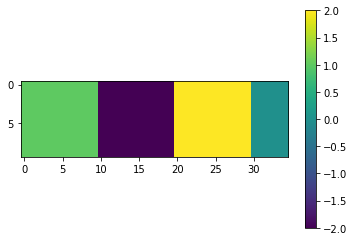

In [95]:
plt.imshow(shrmat[:10, :], vmin = -2, vmax = 2)
plt.colorbar()

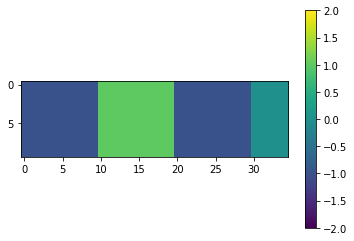

In [97]:
plt.imshow(shrmat[10:20, :], vmin = -2, vmax = 2)
plt.colorbar()

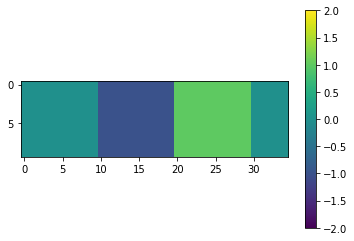

In [98]:
plt.imshow(shrmat[20:30, :], vmin = -2, vmax = 2)
plt.colorbar()

In [102]:
clusters = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
            [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
            [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]

In [ ]:
for elems1 in clusters:
    for elemns2 in clusters:
        

In [88]:
[-2, 2, 1]

[-2, 2, 1]

In [89]:
import random

def cluster(distances, k=3):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)


In [90]:
distmat = - simmat

(array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16,
        10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        34]), array([10, 34, 16, 18]))

In [ ]:
from joblib import Parallel, delayed
from math import sqrt

def unwrap_self(arg, **kwarg):
    return square_class.square_int(*arg, **kwarg)

class square_class:
    def square_int(self, i):
        return i * i
     
    def run(self, num):
        results = []
        results = Parallel(n_jobs= -1, backend=)\
            (delayed(unwrap_self)(i) for i in zip([self]*len(num), num))
        print(results)

square_int = square_class()
square_int.run(num = range(int(1e+08)));